In [283]:
from logging import getLogger
from pathlib import Path
from time import time
import warnings
from tqdm import tqdm 
import sys

import numpy as np
from obp.dataset import linear_reward_function, logistic_reward_function
from obp.dataset import SyntheticBanditDatasetWithActionEmbeds
from obp.ope import RegressionModel
from obp.ope import OffPolicyEvaluation
from obp.ope import InverseProbabilityWeighting as IPS
from obp.ope import BalancedInverseProbabilityWeighting as BIPW
from omegaconf import DictConfig
from ope import run_ope
import pandas as pd
from pandas import DataFrame
from plots import plot_line
from policy import gen_eps_greedy
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning

from src.utils import read_yaml
import matplotlib.pyplot as plt

In [296]:
n_rounds = 20000
n_actions = 1000
dim_context= 10
beta = -1
n_cat_per_dim = 10
latent_param_mat_dim = 5
n_cat_dim = latent_param_mat_dim
n_unobserved_cat_dim = 0
n_def_actions = 0
reward_std = 2.5
random_state = 1

is_optimal = True
eps = 0 #0.05

In [297]:
dataset = SyntheticBanditDatasetWithActionEmbeds(
    n_actions=n_actions,
    dim_context=dim_context,
    beta=beta,
    reward_type="binary",
    n_cat_per_dim=n_cat_per_dim,
    latent_param_mat_dim=latent_param_mat_dim,
    n_cat_dim=n_cat_dim,
    n_unobserved_cat_dim=n_unobserved_cat_dim,
    n_deficient_actions=n_actions*n_def_actions,
    reward_function=logistic_reward_function,
    reward_std=reward_std,
    random_state=random_state,
)

### test bandit data is used to approximate the ground-truth policy value
bandit_data = dataset.obtain_batch_bandit_feedback(
    n_rounds=n_rounds
)

## make decisions on validation data
action_dist = gen_eps_greedy(
    expected_reward=bandit_data["expected_reward"],
    is_optimal=is_optimal,
    eps=eps,
)

In [298]:
from obp.ope import ImportanceWeightEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
action_context_t = scaler.fit_transform(bandit_data["action_context"])

model = MLPClassifier(hidden_layer_sizes=(64,32,32,16), activation='relu', max_iter=400)
iw_estimator = ImportanceWeightEstimator(base_model=model, #(32,32)),
                                             n_actions=bandit_data["n_actions"], 
                                             action_context=action_context_t)
    
imp_weights = iw_estimator.fit_predict(context=bandit_data["context"],
                                        action=bandit_data["action"],
                                        action_dist=action_dist,
                                        random_state=random_state,
                                        evaluate_model_performance=True)

imp_weights = imp_weights / imp_weights.mean()

# iw_estimator.fit(
#     context=bandit_data["context"],
#     action=bandit_data["action"], 
#     action_dist=action_dist
# )

In [133]:
# imp_weights = iw_estimator.predict(context=bandit_data["context"],
#                     action=bandit_data["action"]
#                     )

In [148]:
imp_weights[bandit_data['reward'].astype(bool)].mean()

1.1425811116339337

In [ ]:
((imp_weights) * bandit_data['reward']).mean()

0.17182061899969098

In [ ]:
imp_weights

array([0.05724309, 0.05724309, 0.05724309, ..., 0.05871976, 2.17523651,
       0.05724309])

In [ ]:
proba_eval_policy = iw_estimator.base_model_list[0].predict_proba(X)[:10000,1]
iw = (proba_eval_policy / (1 - proba_eval_policy))
iw[bandit_data['reward'].astype(bool)].mean()

0.5073869302528337

In [ ]:
proba_eval_policy

array([0.05414374, 0.05414374, 0.05414374, ..., 0.05546299, 0.68506283,
       0.05414374])

In [ ]:
proba_eval_policy[proba_eval_policy > 0.5]

array([0.84810605, 0.89958812, 0.82600585, ..., 0.83755995, 0.68506283,
       0.90073826])

In [299]:
from obp.utils import sample_action_fast

position = np.zeros_like(bandit_data["action"])
n = bandit_data["context"].shape[0]

sampled_action = np.zeros(n, dtype=int)
if iw_estimator.fitting_method == "sample":
    for pos_ in np.arange(iw_estimator.len_list):
        idx = position == pos_
        sampled_action_at_position = sample_action_fast(
            action_dist=action_dist[idx][:, :, pos_],
            random_state=1234,
        )
        sampled_action[idx] = sampled_action_at_position

for pos_ in np.arange(iw_estimator.len_list):
    idx = position == pos_
    action_dist_at_pos = action_dist[idx][:, :, pos_]
    X, y = iw_estimator._pre_process_for_clf_model(
        context=bandit_data["context"][idx],
        action=bandit_data["action"][idx],
        action_dist_at_pos=action_dist_at_pos,
        sampled_action_at_position=sampled_action[idx],
    )

X1 = X[:n_rounds]
X2 = X[n_rounds:]

In [306]:
from densratio import densratio

densratio_obj = densratio(X2, X1, alpha=0, sigma_range=[0.1, 0.3, 0.5, 0.7, 1], lambda_range=[0.01, 0.02, 0.03, 0.04, 0.05], verbose=True)
# print(densratio_obj)

RuLSIF starting...
Searching for the optimal sigma and lambda...
sigma = 0.10000, lambda = 0.01000, score = -0.00000
sigma = 0.10000, lambda = 0.02000, score = -0.00000
sigma = 0.10000, lambda = 0.03000, score = -0.00000
sigma = 0.10000, lambda = 0.04000, score = -0.00000
sigma = 0.10000, lambda = 0.05000, score = -0.00000
sigma = 0.30000, lambda = 0.01000, score = -0.00000
sigma = 0.30000, lambda = 0.02000, score = -0.00000
sigma = 0.30000, lambda = 0.03000, score = -0.00000
sigma = 0.30000, lambda = 0.04000, score = -0.00000
sigma = 0.30000, lambda = 0.05000, score = -0.00000
sigma = 0.50000, lambda = 0.01000, score = -0.00001
sigma = 0.50000, lambda = 0.02000, score = -0.00000
sigma = 0.50000, lambda = 0.03000, score = -0.00000
sigma = 0.50000, lambda = 0.04000, score = -0.00000
sigma = 0.50000, lambda = 0.05000, score = -0.00000
sigma = 0.70000, lambda = 0.01000, score = -0.00021
sigma = 0.70000, lambda = 0.02000, score = -0.00011
sigma = 0.70000, lambda = 0.03000, score = -0.00007

In [307]:
imp_weights = densratio_obj.compute_density_ratio(X[:n_rounds])
imp_weights = imp_weights / imp_weights.mean()

(array([  12.,  127.,  650., 1729., 2791., 2674., 1460.,  446.,  101.,
          10.]),
 array([-3.66311141, -2.91185944, -2.16060747, -1.4093555 , -0.65810353,
         0.09314844,  0.84440041,  1.59565238,  2.34690435,  3.09815632,
         3.84940829]),
 <BarContainer object of 10 artists>)

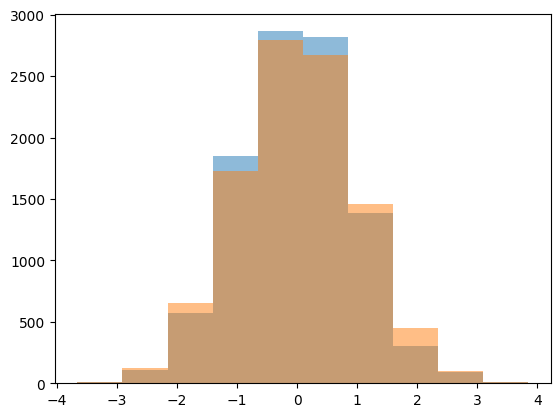

In [116]:
dim = 0
plt.hist(X[:10000, dim], alpha=0.5, weights=imp_weights)
plt.hist(X[10000:, dim], alpha=0.5)

In [ ]:
X[10000:]

array([[-0.82899501,  5.        ],
       [-0.56018104,  5.        ],
       [ 0.74729361,  2.        ],
       ...,
       [ 1.57458636,  5.        ],
       [ 1.08648012,  2.        ],
       [ 0.44575985,  2.        ]])

In [268]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

model = MLPClassifier(hidden_layer_sizes=(32,32,32), activation='relu', max_iter=400)
# model = LogisticRegression()
# model = RandomForestClassifier()

cv_results = cross_validate(model, X, y, cv=3)

In [269]:
cv_results['test_score']

array([0.92095395, 0.91045448, 0.92649265])

In [143]:
model = RandomForestClassifier()
model = MLPClassifier()

model.fit(X, y)

y_pred = model.predict(X)
sum(y_pred == y) / len(y)

/Users/thepoch/opt/miniconda3/envs/ope/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.96095

In [144]:
proba_eval_policy = model.predict_proba(X)[:, 1]

In [ ]:
(proba_eval_policy / (1 - proba_eval_policy))

/var/folders/kt/d510b2jj6vscmdv_qwvjcgp00000gn/T/ipykernel_50699/3836169021.py:1: RuntimeWarning: divide by zero encountered in divide
  (proba_eval_policy / (1 - proba_eval_policy))


array([ 0.03092784,  0.17647059,  0.08695652, ...,  2.33333333,
       13.28571429, 24.        ])

In [ ]:
a = proba_eval_policy[(proba_eval_policy < 1)]
(a / (1-a)).mean()

14.061025601913098

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator

isinstance(MLPClassifier(), BaseEstimator)

True

In [150]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
context_t = scaler.fit_transform(bandit_data["action_context"])

In [151]:
context_t.shape

(1000, 20)

In [308]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.5)

kde.fit(X1, sample_weight=imp_weights)
log_density = kde.score_samples(X1)
prob1 = np.exp(log_density)
#prob1 = prob1 / prob1.sum()

kde = KernelDensity(kernel='gaussian', bandwidth=0.5)

kde.fit(X2)
log_density = kde.score_samples(X1)
prob2 = np.exp(log_density)
#prob2 = prob2 / prob2.sum()


In [309]:
entropy(prob1, prob2)

2.521577506860904

In [256]:
entropy(prob1, prob2)

6.799121310305228

In [194]:
from scipy.special import kl_div, rel_entr
from scipy.stats import entropy

sum(rel_entr(prob1, prob2))

0.005130973136501334

In [192]:
prob1

array([1.0105833 , 1.01323716, 0.98744396, ..., 0.98350465, 1.03824797,
       0.98311687])

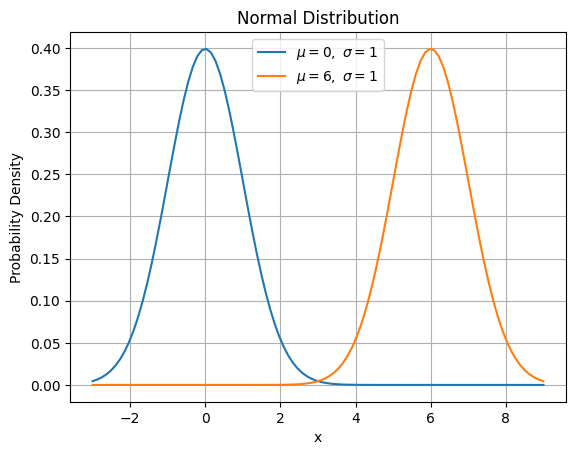

In [228]:
from scipy.stats import norm

# Mean and standard deviation
mu1 = 0  # mean
mu2 = 6
sigma = 1  # standard deviation

# Create a range of x values
x = np.linspace(mu1 - 3*sigma, mu2 + 3*sigma, 100)

# Generate the density of the normal distribution
pdf1 = norm.pdf(x, mu1, sigma)
pdf2 = norm.pdf(x, mu2, sigma)

# Plotting
plt.plot(x, pdf1, label=f'$\mu={mu1},\ \sigma={sigma}$')
plt.plot(x, pdf2, label=f'$\mu={mu2},\ \sigma={sigma}$')
plt.title('Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [229]:
entropy(pdf1, pdf2)

17.97795924415429

In [240]:
(X1[:, 10:] == X2[:, 10:]).prod(axis=1).sum()

8

In [238]:
X1[:, 10:].prod(axis=1)

array([ 756000.,  235200.,       0., ..., 6350400.,       0.,       0.])